## What is this notebook about?

This notebook was used to create ```Fig.4A```,```Fig.C1``` and the analyis numbers referenced in the text.

The numbers calculated here and other notebooks will be stored under the filepath indicated by the variable `data_reports_fp` for future reference.

In [1]:
# Some imports to get things started
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

sys.path.insert(1, os.path.abspath('/..'))
from utils import set_aspect,save_descriptive_stats
from pathlib import Path

In [2]:
# Load the donation info from the data dable
donation_table = pd.read_csv(Path('../data/donation_table.csv'))

# Load messages including those from non-interactive chats
messages_table = pd.read_csv(Path('../data/messages_table.csv'))

# Load filtered messages only from interactive chats
messages_filtered_table = pd.read_csv(Path('../data/messages_filtered_table.csv'))

# Load the quesionnaire answers 
survey_info = pd.read_excel(Path('../data/survey.xlsx'))

# Where to save numbers from the analysis
data_reports_fp = Path('../reports/numbers.dat')

# Where to save figures from the analysis
figpath = Path('../reports')

# Which colors to use to plot data from different messengers
WhatsApp_color = '#3dc24f'
Facebook_color = '#385999'

In [3]:
def calculate_bias(ego_wc, total_wc):
    """
    Calculate the chat bias by taking the ratio between the words contributed
    by ego and alters and subtracting the result from 0.5. This results in values
    betweeen -0.5 and 0.5. Zero indicates no bias, while negative and positive 
    values indicate more ego(donor) and alter(contact) contributions, respectively. 
    """
    return np.subtract(0.5,np.divide(ego_wc,total_wc))

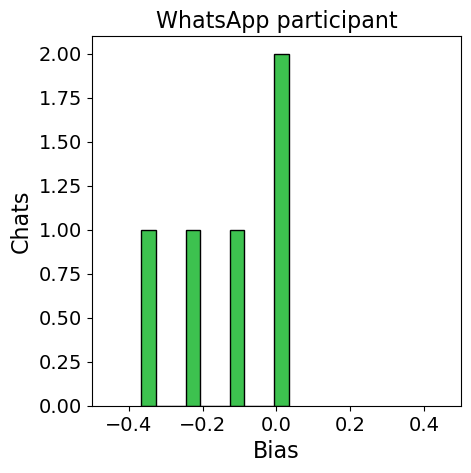

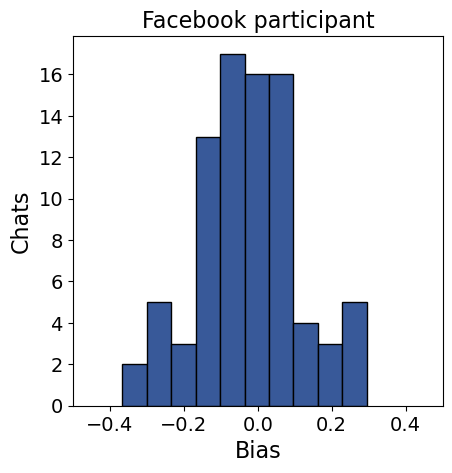

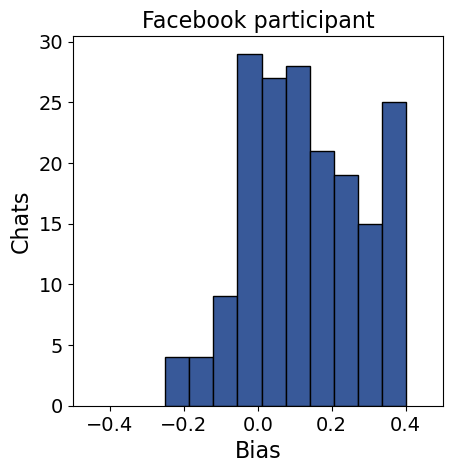

In [4]:
all_biases = []
exampleIDs = ['d119b841-c699-498b-8e9d-498fb99c941e',
              'e1c1129f-42d2-4d50-a4fb-27168db1a261','5b56ab78-7f25-4270-b0cf-1d87f383cab0']

for source,color in zip(['WhatsApp','Facebook'],[WhatsApp_color,Facebook_color]):
    sourceIDs = donation_table[donation_table['source'] == source]['donation_id']
    source_biases = []
    source_interactive = []
    for donationID in sourceIDs:
        # Get the donor_id for the donation to be able to separate the donor messages
        egoID = donation_table[donation_table['donation_id']==donationID]['donor_id'].iloc[0]
        
        # Separate messages for a given dontion
        donation_messages = messages_filtered_table[messages_filtered_table['donation_id']==donationID]
        
        # Get chatIDs in a given donation
        chatIDs = donation_messages['conversation_id'].unique()
        
        # Calculate the share of interactive chats by taking the ratio between the filtered and unfiltered chats
        unfiltered_messages = messages_table[messages_table['donation_id']==donationID]
        chats_unfiltered = unfiltered_messages['conversation_id'].unique()
        source_interactive.append(len(chatIDs)/len(chats_unfiltered))
        
        chat_biases = []
        for chatID in chatIDs:
            # Separate messages in a given chat
            chat_messages = donation_messages[donation_messages['conversation_id']==chatID]
            
            # Separate messages sent by the donor
            ego_chat_messages = chat_messages[chat_messages['sender_id']==egoID]
            
            # Calculate the chat bias
            chat_bias = calculate_bias(ego_chat_messages['word_count'].sum(),chat_messages['word_count'].sum())
            chat_biases.append(chat_bias)
            
        # Create example plots for bias distributions for 3 donors (Fig C1)
        if donationID in exampleIDs:
            
            fig,ax = plt.subplots()
            ax.hist(chat_biases,color=color,edgecolor='k')
            ax.set_xlabel('Bias',fontsize=16)
            ax.set_ylabel('Chats',fontsize=16)
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.set_title(f'{source} participant',fontsize=16)
            ax.set_xlim(-0.5,0.5)
            set_aspect(ax)
            fig.patch.set_facecolor('white')
            fig.savefig(Path(f'{figpath}/bias-{donationID}.png'),dpi=500)
            
        # Save values for calculating sample stats    
        source_biases.append(np.median(chat_biases))
        all_biases.append(np.median(chat_biases))
        
    # Calculate and save sample stats of the median biases for each source
    save_descriptive_stats(data_reports_fp,f'{source}-medians',source_biases)
    
    # Calculate and save the sample stats of interactive chats for each source
    save_descriptive_stats(data_reports_fp,f'{source}_interactive_share',source_interactive)

# Calculate and save save sample stats of the median biases for both sources
save_descriptive_stats(data_reports_fp,f'all-medians',all_biases)

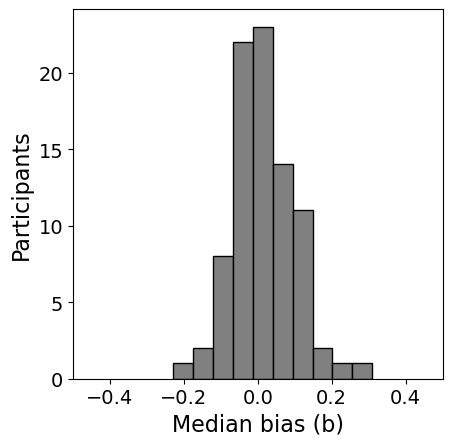

In [5]:
# Plot Fig. 4B
fig, ax = plt.subplots()
all_biases = [np.round(item, 2) for item in all_biases] # this is not really necessary but results in the exact same figure as in the paper
ax.hist(all_biases,color='gray',edgecolor='black')
ax.set_xlabel('Median bias (b)', fontsize=16)
ax.set_ylabel('Participants', fontsize=16)
ax.set_xlim(-0.5,0.5)
ax.tick_params(axis='both', which='major', labelsize=14)
set_aspect(ax)
fig.patch.set_facecolor('white')
fig.savefig(Path(f'{figpath}/bias-medians-hist.png'),dpi=500)
fig.savefig(Path(f'{figpath}/bias-medians-hist.svg'),dpi=500)